## Shape recognition 

In [19]:
import numpy as np
import json
import pickle


## Load training data

In [20]:
seq_length=100
img_size=20


def normalize_points(lpoints):
    p=np.array(lpoints)
    p=p-p.min(axis=0)
    return p/(p.max()+0.01)

def iter_training():
    for line in open("training.json"):
        obj=json.loads(line.strip())
        yield obj["shape"],obj["points"]

def iter_normalized():
    for shape,points in iter_training():
        if shape!="?" and len(points)>20:
            yield shape,normalize_points(points)

def iter_sequences(size):
    for shape,points in iter_normalized():
        seq=np.array(lpoints[:size])
        if len(lpoints)<size:
            seq=np.pad(seq,pad_width=( (0,size-len(lpoints)) , (0,0) ), mode="edge")
        yield shape,seq
        

def iter_images():
    for shape,points in iter_normalized():
        img=np.zeros((img_size,img_size))
        for y,x in np.rollaxis(points, 0):
            img[int(x*img_size),int(y*img_size)]=1.0
        yield shape,img.reshape(img_size,img_size,1)


In [21]:
for s,p in iter_images():
    print(s,p.shape)

hline (20, 20, 1)
hline (20, 20, 1)
elipse (20, 20, 1)
vline (20, 20, 1)
vline (20, 20, 1)
triangle (20, 20, 1)
elipse (20, 20, 1)
vline (20, 20, 1)
triangle (20, 20, 1)
elipse (20, 20, 1)
elipse (20, 20, 1)
vline (20, 20, 1)
rectangle (20, 20, 1)
triangle (20, 20, 1)
sigma (20, 20, 1)
sigma (20, 20, 1)
rectangle (20, 20, 1)
vline (20, 20, 1)
rectangle (20, 20, 1)
elipse (20, 20, 1)
sigma (20, 20, 1)
sigma (20, 20, 1)
triangle (20, 20, 1)
hline (20, 20, 1)
rectangle (20, 20, 1)
sigma (20, 20, 1)
triangle (20, 20, 1)
elipse (20, 20, 1)
vline (20, 20, 1)
elipse (20, 20, 1)
triangle (20, 20, 1)
triangle (20, 20, 1)
hline (20, 20, 1)
triangle (20, 20, 1)
hline (20, 20, 1)
rectangle (20, 20, 1)
elipse (20, 20, 1)
hline (20, 20, 1)
hline (20, 20, 1)
vline (20, 20, 1)
elipse (20, 20, 1)
elipse (20, 20, 1)
hline (20, 20, 1)
sigma (20, 20, 1)
hline (20, 20, 1)
hline (20, 20, 1)
elipse (20, 20, 1)
triangle (20, 20, 1)
vline (20, 20, 1)
triangle (20, 20, 1)
rectangle (20, 20, 1)
vline (20, 20, 1)

leftbracket (20, 20, 1)
leftbracket (20, 20, 1)
triangle (20, 20, 1)
vline (20, 20, 1)
rightbracket (20, 20, 1)
vline (20, 20, 1)
triangle (20, 20, 1)
rectangle (20, 20, 1)
rectangle (20, 20, 1)
elipse (20, 20, 1)
elipse (20, 20, 1)
sigma (20, 20, 1)
integral (20, 20, 1)
hline (20, 20, 1)
elipse (20, 20, 1)
hline (20, 20, 1)
sigma (20, 20, 1)
elipse (20, 20, 1)
rectangle (20, 20, 1)
integral (20, 20, 1)
vline (20, 20, 1)
sigma (20, 20, 1)
triangle (20, 20, 1)
leftbracket (20, 20, 1)
triangle (20, 20, 1)
rectangle (20, 20, 1)
rectangle (20, 20, 1)
leftbracket (20, 20, 1)
rectangle (20, 20, 1)
elipse (20, 20, 1)
triangle (20, 20, 1)
rectangle (20, 20, 1)
rightbracket (20, 20, 1)
rectangle (20, 20, 1)
rightbracket (20, 20, 1)
triangle (20, 20, 1)
elipse (20, 20, 1)
rectangle (20, 20, 1)
sigma (20, 20, 1)
elipse (20, 20, 1)
integral (20, 20, 1)
elipse (20, 20, 1)
rectangle (20, 20, 1)
integral (20, 20, 1)
hline (20, 20, 1)
hline (20, 20, 1)
sigma (20, 20, 1)
elipse (20, 20, 1)
vline (20, 2

In [22]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [23]:
X=np.array([p for _,p in iter_images() ])
X.shape

(916, 20, 20, 1)

In [24]:
yLabel=[label for label,_ in iter_normalized() ]
labelEncoder=LabelEncoder().fit(yLabel)
num_classes=len(labelEncoder.classes_)
y=to_categorical(labelEncoder.transform(yLabel))
y.shape

(916, 13)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [26]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(img_size,img_size,1)))
model.add(Conv2D(16, kernel_size=(3,3),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 17, 17, 32)        544       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                108030    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)               

In [37]:
model.compile(loss=categorical_crossentropy,optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_data=(X_test,y_test))
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
74/74 [==============================] - 1s 9ms/step - loss: 0.1224 - accuracy: 0.9549 - val_loss: 0.5605 - val_accuracy: 0.8913
Epoch 2/20
74/74 [==============================] - 1s 8ms/step - loss: 0.1083 - accuracy: 0.9590 - val_loss: 0.4879 - val_accuracy: 0.8967
Epoch 3/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0789 - accuracy: 0.9713 - val_loss: 0.5142 - val_accuracy: 0.8804
Epoch 4/20
74/74 [==============================] - 1s 9ms/step - loss: 0.0911 - accuracy: 0.9658 - val_loss: 0.5736 - val_accuracy: 0.9022
Epoch 5/20
74/74 [==============================] - 1s 9ms/step - loss: 0.0845 - accuracy: 0.9686 - val_loss: 0.5457 - val_accuracy: 0.9022
Epoch 6/20
74/74 [==============================] - 1s 13ms/step - loss: 0.0784 - accuracy: 0.9768 - val_loss: 0.6085 - val_accuracy: 0.8913
Epoch 7/20
74/74 [==============================] - 1s 14ms/step - loss: 0.0830 - accuracy: 0.9740 - val_loss: 0.5020 - val_accuracy: 0.9022
Epoch 8/20
74/74 [

In [28]:
model.save("shape_prediction_model")

pickle.dump(labelEncoder,open("shape_prediction_model/assets/labelEncoder.pickle","wb"))

INFO:tensorflow:Assets written to: shape_prediction_model/assets


In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
predictions=model.predict(X)
predictedLabels=labelEncoder.inverse_transform(predictions.argmax(axis=1))

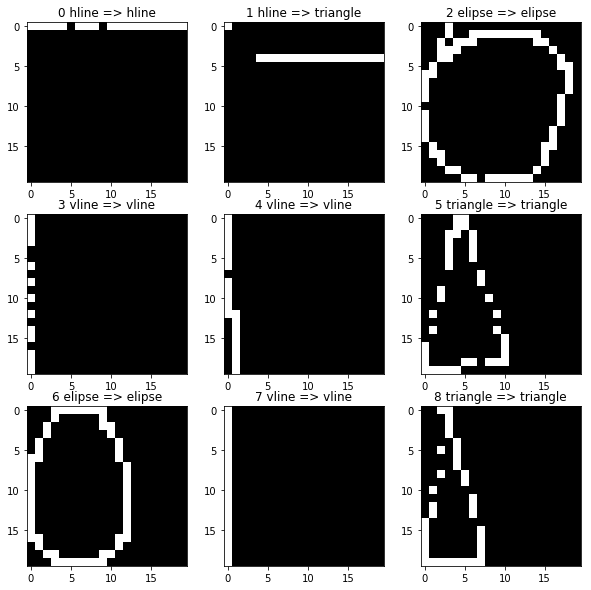

In [40]:
def show_plot(indices):
    plt.figure(figsize=(10,10))
    for p,i in enumerate(indices[:9]):
        plt.subplot(3,3,p+1)
        plt.imshow(X[i].reshape(img_size,img_size), cmap='gray', interpolation='none')
        plt.title("{} {} => {}".format(i,yLabel[i],predictedLabels[i]))

show_plot(range(9))

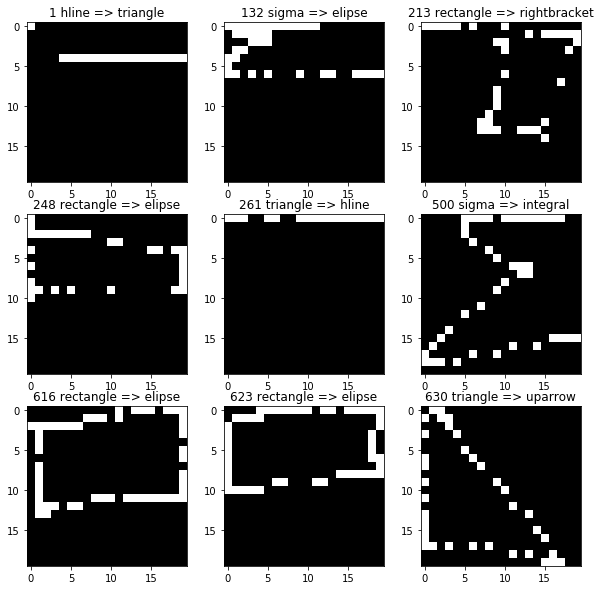

In [41]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

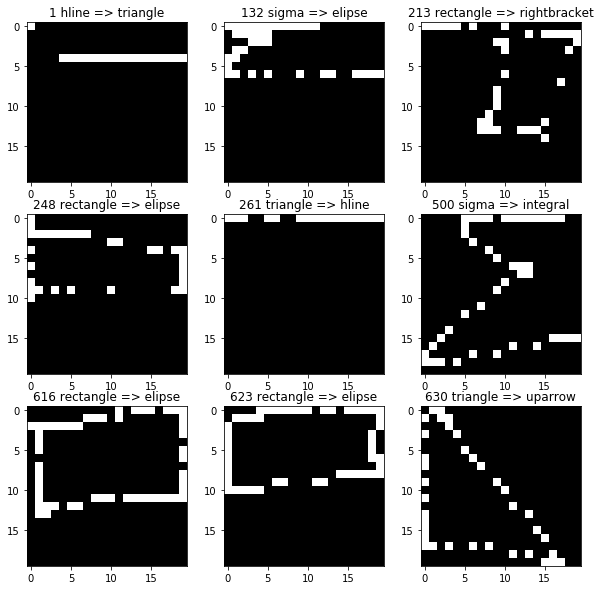

In [42]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

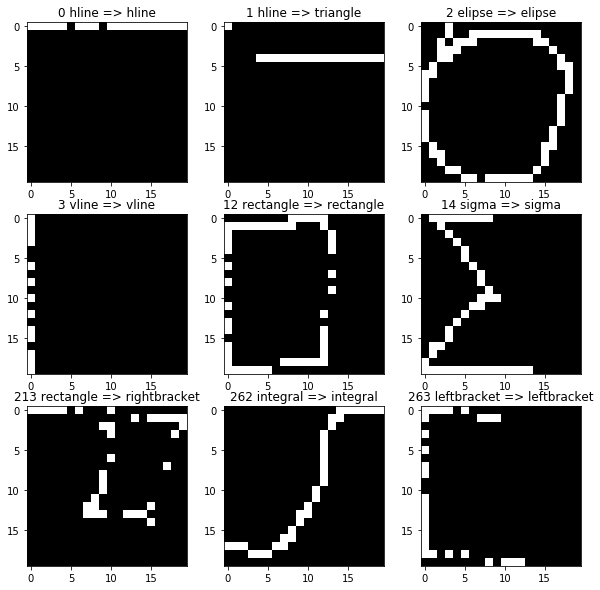

In [43]:
indices=[]
foundclasses=set(predictedLabels)
for i,c in enumerate(predictedLabels):
    if c in foundclasses:
        indices.append(i)
        foundclasses.remove(c)

show_plot(indices)

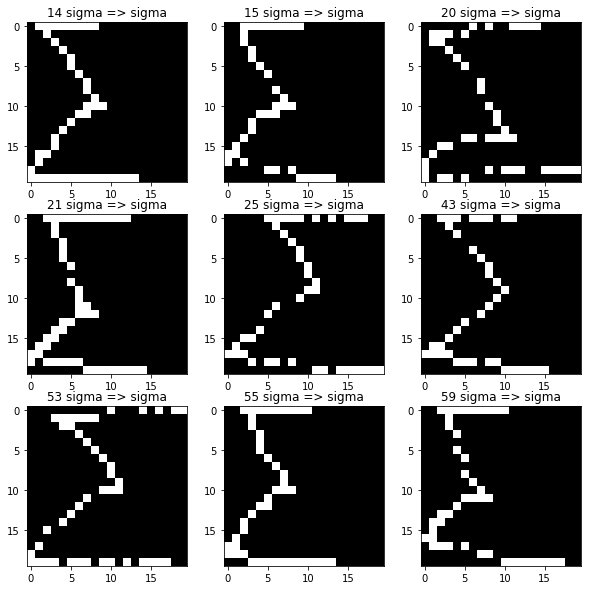

In [44]:
indices=[i for i,good in enumerate(predictedLabels=="sigma") if good]
show_plot(indices)

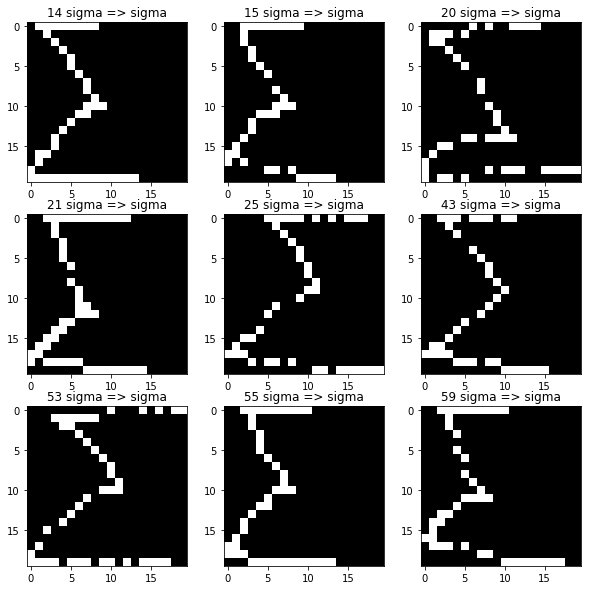

In [45]:
indices=[i for i,good in enumerate(np.array(yLabel)=="sigma") if good]
show_plot(indices)